In [1]:
# optional but useful for debugging - reimports modules after editing and saving .py files
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np, pandas as pd, scipy
import astropy
from astropy import units as u
import astromet
import matplotlib.pyplot as plt
import matplotlib as mpl
import tqdm
import scanninglaw.times
from scanninglaw.source import Source
from astropy.time import Time

In [4]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=2
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5

plt.rcParams['figure.figsize'] = [10, 7]

mas=astromet.mas

In [6]:
# slooow step - see scanning_law package for details
scanninglaw.times.fetch(version='dr3_nominal')
dr3_sl=scanninglaw.times.Times(version='dr3_nominal')

  0.0 B of 543.4 MiB |   0.0 s/B |                      |   0% | ETA:  --:--:--

543.4 MiB of 543.4 MiB |  11.1 MiB/s |##################| 100% | ETA:  00:00:00


Loading auxilliary data ...
t = 43.850 s
  auxilliary:  20.697 s
          sf:   6.524 s
interpolator:  16.630 s


# Lensing event

In [7]:
# System astrometry parameters
params=astromet.params()

# source
params.ra=360*np.random.rand()
params.dec=np.arcsin(-1+2*np.random.rand())*180/np.pi
params.parallax=1/np.random.uniform(4,8)
params.pmrac=params.parallax*(10/3)*np.random.randn()
params.pmdec=params.parallax*(10/3)*np.random.randn()

# lensing
params.blendparallax=1/np.random.uniform(0.5,params.parallax)
params.blendpmrac=params.blendparallax*(10/3)*np.random.randn()
params.blendpmdec=params.blendparallax*(10/3)*np.random.randn()
params.blenddrac=np.random.uniform(0,5)
params.blendddec=np.random.uniform(0,5)
params.thetaE=10**np.random.uniform(-1,2)
params.fbl=1

mag_baseline=np.random.rand()*6+11 

# get Gaia scanning pattern for the field
c=Source(params.ra,params.dec,unit='deg')
sl=dr3_sl(c, return_times=True, return_angles=True)
ts=2010+np.squeeze(np.hstack(sl['times']))/365.25
sort=np.argsort(ts)
ts=np.double(ts[sort])
phis=np.double(np.squeeze(np.hstack(sl['angles']))[sort])

# epochs for plotting continuous tracks
ts_dense=np.linspace(ts[0],ts[-1],1000)

In [8]:
params.ra, params.dec, params.parallax, params.pmrac, params.pmdec, mag_baseline

(167.95071087018204,
 52.812999095254405,
 0.20508474305439103,
 0.19379604249679983,
 -1.4123855867201482,
 12.524193690156702)

In [9]:
params.blendparallax, params.blendpmrac, params.blendpmdec, params.blenddrac, params.blendddec

(2.5028414699007726,
 3.252753479722391,
 -13.417797417418624,
 0.8649448497266532,
 0.6335792277289531)

In [10]:
params.thetaE, params.fbl

(26.232912243695743, 1)

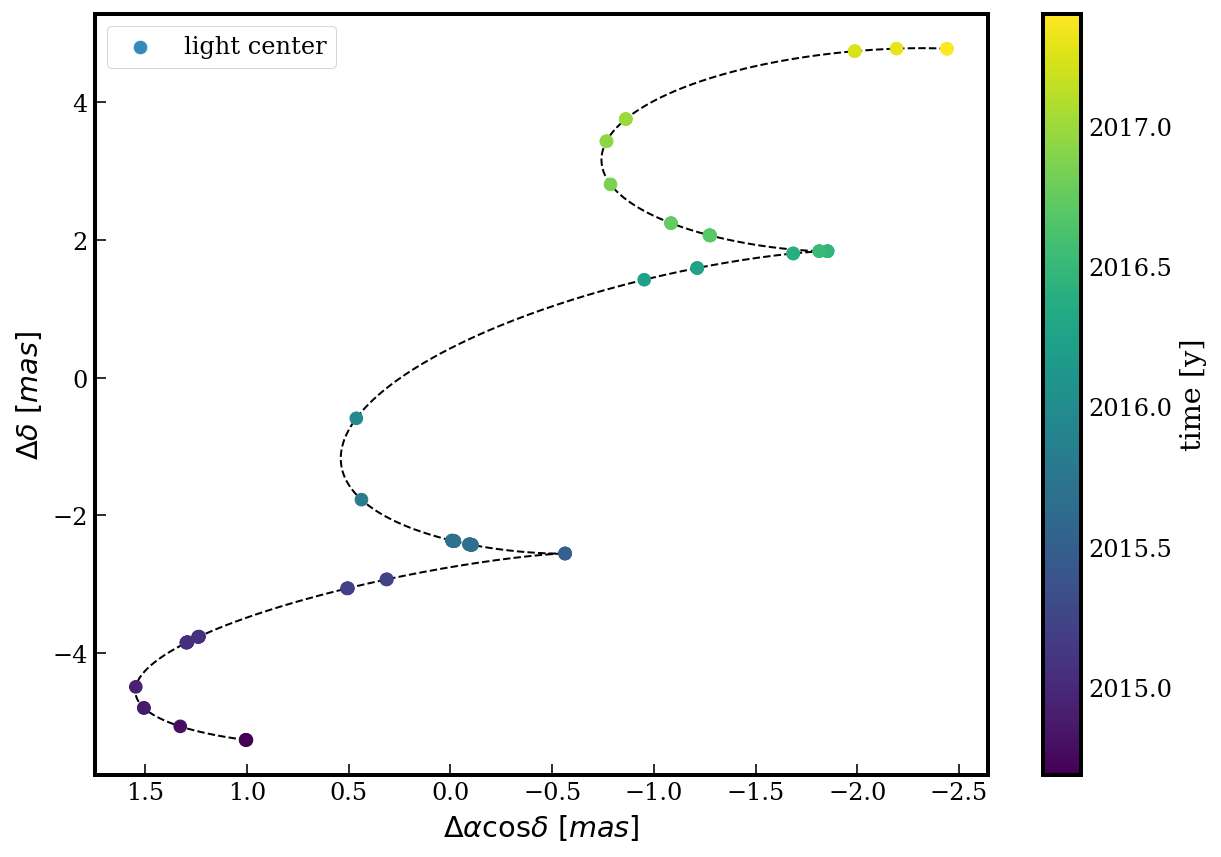

In [11]:
# generate and plot lensed track
drac, ddec, mag_diff = astromet.track(ts, params)
drac_dense, ddec_dense, mag_diff_dense = astromet.track(ts_dense, params)

ax=plt.gca()
im = ax.scatter(drac, ddec, s=40, c=ts, zorder=3, label="light center")
ax.plot(drac_dense, ddec_dense, ls='--', lw=1, color='black')

ax.set_xlabel(r'$\Delta \alpha \cos \delta \ [mas]$')
ax.set_ylabel(r'$\Delta \delta \ [mas]$')
ax.grid(True, alpha=0.3)
plt.legend()
#plt.axis('equal')
ax.invert_xaxis()

cbar = plt.colorbar(im)
cbar.set_label("time [y]")

plt.show()

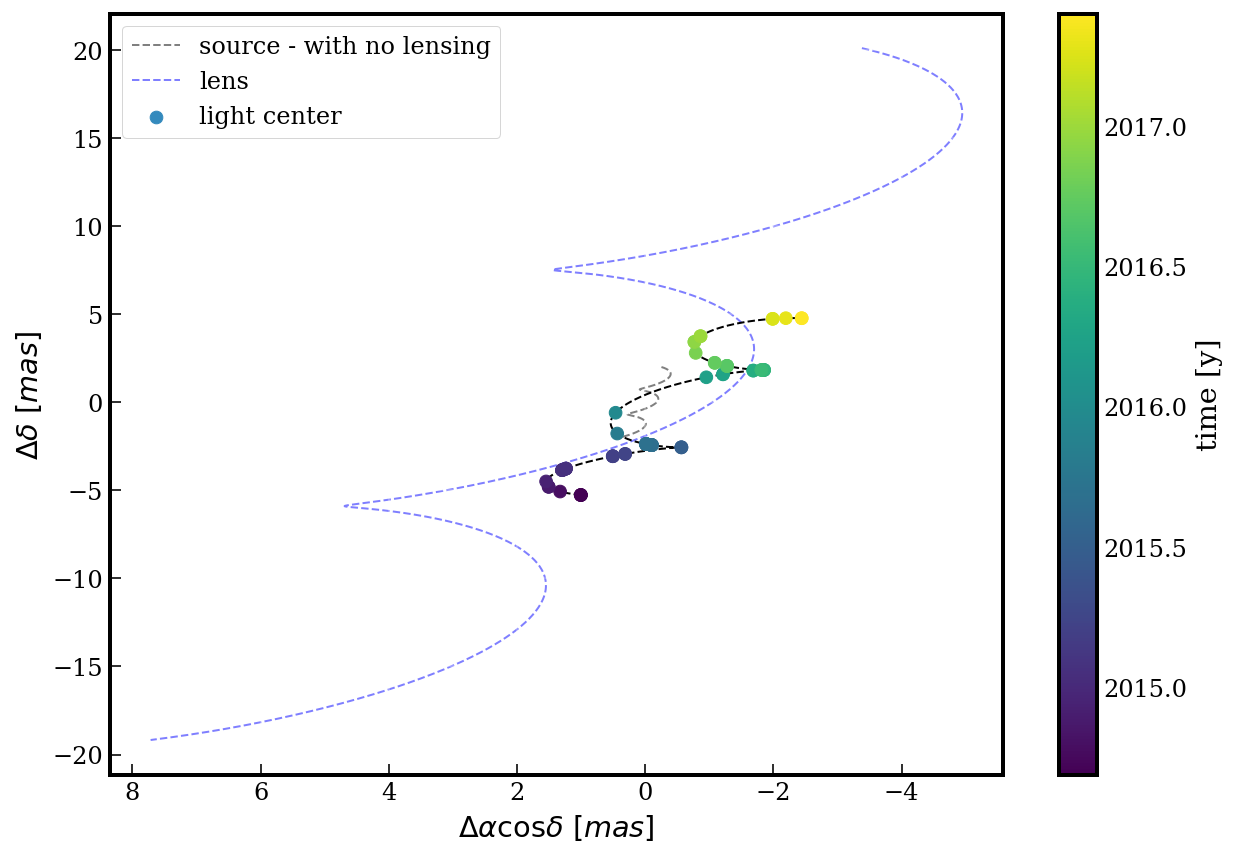

In [12]:
# plot all tracks, incl. source and lens
params_source = astromet.params()
params_source.ra, params_source.dec, params_source.parallax, params_source.pmrac, params_source.pmdec = params.ra, params.dec, params.parallax, params.pmrac, params.pmdec
params_lens = astromet.params()
params_lens.ra, params_lens.dec, params_lens.parallax, params_lens.pmrac, params_lens.pmdec = params.ra, params.dec, params.blendparallax, params.blendpmrac, params.blendpmdec
params_lens.drac, params_lens.ddec = params.blenddrac, params.blendddec

drac_source, ddec_source = astromet.track(ts_dense, params_source)
drac_lens, ddec_lens = astromet.track(ts_dense, params_lens)

ax=plt.gca()
im = ax.scatter(drac, ddec, s=40, c=ts, zorder=3, label="light center")
ax.plot(drac_dense, ddec_dense, ls='--', lw=1, color='black')

ax.plot(drac_source, ddec_source, '--', color='grey', lw=1, zorder=0, label="source - with no lensing")
ax.plot(drac_lens, ddec_lens, '--', color='blue',lw=1, zorder=0, alpha=0.5, label="lens")

ax.set_xlabel(r'$\Delta \alpha \cos \delta \ [mas]$')
ax.set_ylabel(r'$\Delta \delta \ [mas]$')
ax.grid(True, alpha=0.3)
plt.legend()
#plt.axis('equal')
ax.invert_xaxis()

cbar = plt.colorbar(im)
cbar.set_label("time [y]")

plt.show()

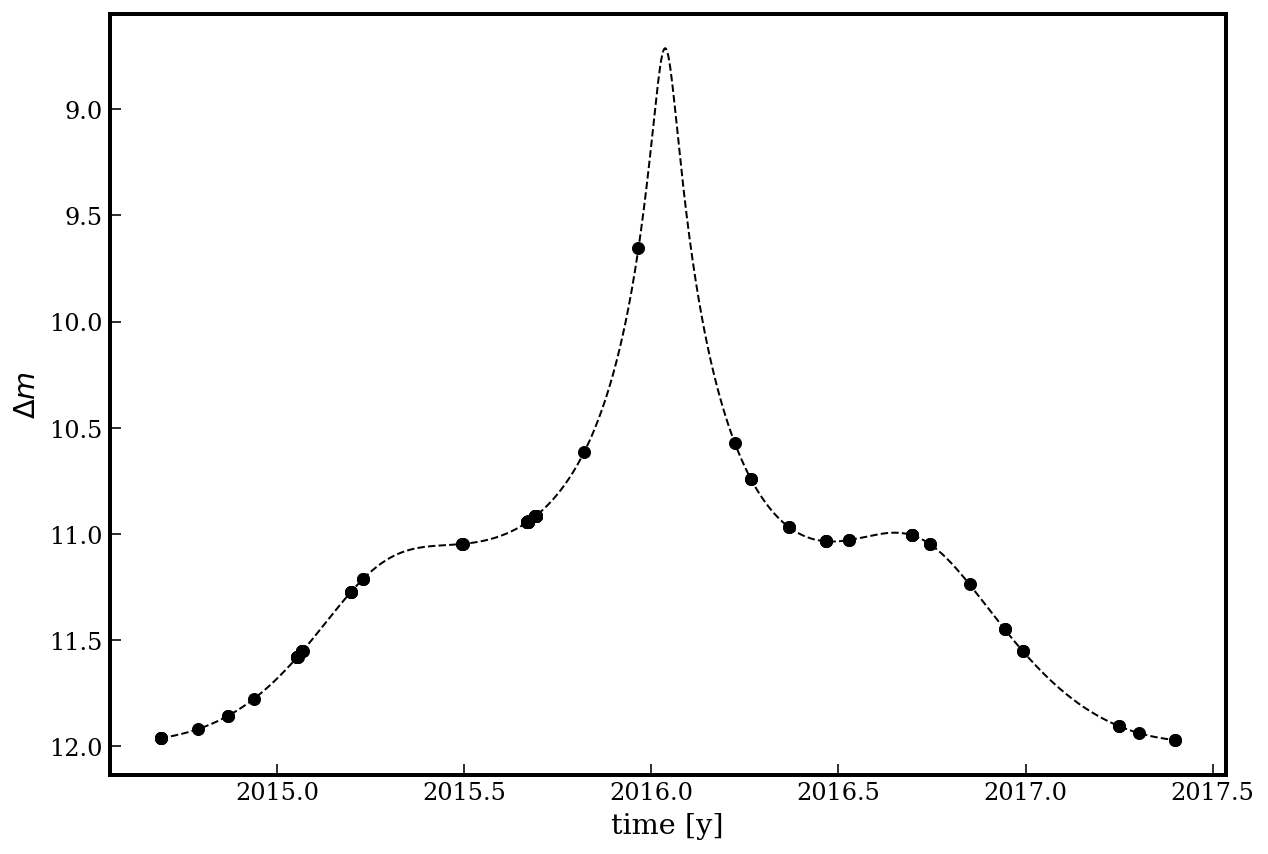

In [13]:
# lightcurve
mag_lensed = mag_diff + mag_baseline
mag_lensed_dense = mag_diff_dense + mag_baseline
plt.scatter(ts, mag_lensed, color='black')
plt.plot(ts_dense, mag_lensed_dense, lw=1, ls='--', color='black')
plt.gca().set_ylabel(r'$\Delta m$')
plt.gca().set_xlabel('time [y]')
plt.gca().invert_yaxis()
plt.grid()
plt.show()

# Mock observations and fits

In [14]:
### create mock obs with astromet
x_err = np.repeat(astromet.sigma_ast(mag_lensed),9)
t_obs,x_obs,phi_obs,rac_obs,dec_obs=astromet.mock_obs(ts,phis,drac,ddec,err=x_err)

In [15]:
# fit
# 'pmra' in gaia data is pmra*cos(dec) 
results=astromet.fit(t_obs,x_obs,phi_obs,x_err,params.ra,params.dec)
gaia_output=astromet.gaia_results(results)
gaia_output

{'astrometric_matched_transits': 74,
 'visibility_periods_used': 25,
 'astrometric_n_obs_al': 666,
 'astrometric_params_solved': 31,
 'ra': 167.9507110108699,
 'ra_error': 0.01241804591188232,
 'dec': 52.81299901455536,
 'dec_error': 0.01634772314671279,
 'ra_dec_corr': 0.020977475381009015,
 'parallax': -0.6330358726025067,
 'parallax_error': 0.023642474564733056,
 'ra_parallax_corr': -0.05834089939015317,
 'dec_parallax_corr': 0.1156776867438012,
 'pmra': -1.1438225657262224,
 'pmra_error': 0.018191252232387732,
 'ra_pmra_corr': 0.29835469687978683,
 'dec_pmra_corr': -0.2340693297376391,
 'parallax_pmra_corr': -0.15587847375643252,
 'pmdec': 3.888242519265051,
 'pmdec_error': 0.019132019489620743,
 'ra_pmdec_corr': -0.14793458241662252,
 'dec_pmdec_corr': 0.023359629886849226,
 'parallax_pmdec_corr': 0.18472987868210133,
 'pmra_pmdec_corr': 0.12230909545402868,
 'astrometric_excess_noise': 0.1691856561667951,
 'astrometric_chi2_al': 1676.2217737501464,
 'astrometric_n_good_obs_al': 6

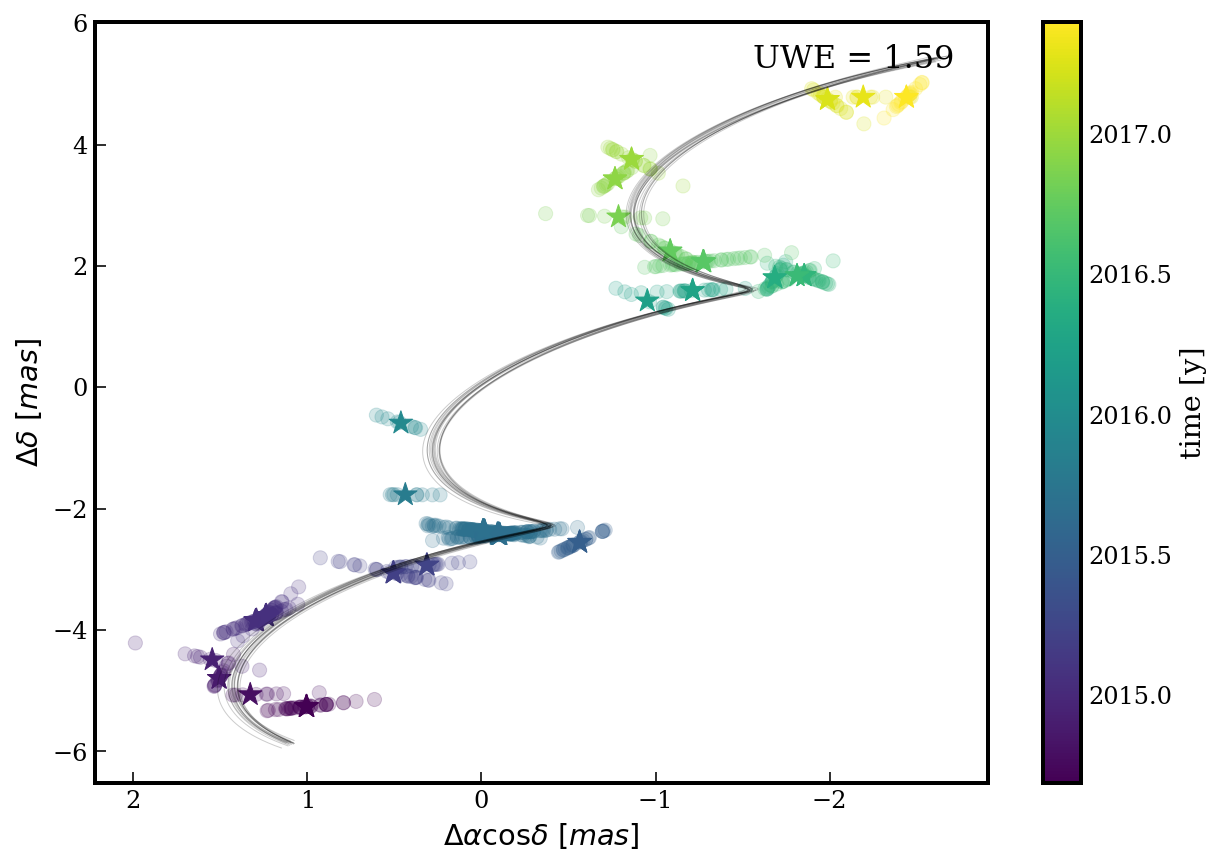

In [16]:
# plot track & fits
plotts=np.linspace(ts[0],ts[-1],1000)

ax=plt.gca()
fitparams=astromet.params()
for i in range(16):
    fitparams.ra=params.ra
    fitparams.dec=params.dec
    fitparams.drac=results['drac']+np.random.randn()*results['drac_error']
    fitparams.ddec=results['ddec']+np.random.randn()*results['ddec_error']
    fitparams.pmrac=results['pmrac']+np.random.randn()*results['pmrac_error']
    fitparams.pmdec=results['pmdec']+np.random.randn()*results['pmdec_error']
    fitparams.parallax=results['parallax']+np.random.randn()*results['parallax_error']

    fitRacs,fitDecs=astromet.track(plotts,fitparams)
    ax.plot(fitRacs,fitDecs,c='k',alpha=0.2,lw=0.5)

    
#plt.axis('equal')
plt.scatter(rac_obs, dec_obs, c=t_obs,s=50,alpha=0.2)

im=plt.scatter(drac, ddec, c=ts, s=150, marker='*', alpha=1)

ax.set_xlabel(r'$\Delta \alpha \cos \delta \ [mas]$')
ax.set_ylabel(r'$\Delta \delta \ [mas]$')
ax.invert_xaxis()
uwe = round(gaia_output['UWE'],2)
ax.text(0.85, 0.95, f'UWE = {uwe}', ha='center', va='center', transform=ax.transAxes, fontsize=16)


cbar = plt.colorbar(im)
cbar.set_label("time [y]")

plt.show()